In [4]:
import os
print(os.getcwd())

C:\Users\em18921\Documents\Sentinels_indicator\Codes_folder


In [10]:
import glob
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore
from statsmodels.tsa.seasonal import STL
import re

# Function to create weekly change in SVI files

In [4]:
def weekly_change_svi(df):
    # Sort the dataframe by year, month, day and groupby keyword_name
    df_sorted = df.sort_values(by=['keyword_name', 'Year', 'Month'])

    # Groupby keyword name
    grouped = df_sorted.groupby('keyword_name')

    Delta_SVI = df_sorted.copy()

    Delta_SVI[f"delta_SVI"] = grouped['SVI'].diff()

    return Delta_SVI

# Creating weekly change in SVI for geopolitics file

In [6]:
# Step 1: Import the dataset
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\geopoltiks_mon_final_dataset_2.csv'
df_geo = pd.read_csv(input_file_path, low_memory=False)

# Step 2: Replace '<1' value to 0
df_geo['SVI'] = df_geo['SVI'].replace('<1', 0)

# Step 3: Convert SVI column to numeric
df_geo['SVI'] = pd.to_numeric(df_geo['SVI'], errors='coerce')

# Step 4: Remove rows with less than 10 SVIs
df_geo = df_geo[df_geo['SVI'] >= 0]

# Step 2: Apply the function weekly change SVI to the above dataset
df_weekly_change_geo = weekly_change_svi(df_geo)

# Step 3: Output the answer file
#output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\geopoltiks_cal_1.csv'
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_1_zhi_da.csv'
df_weekly_change_geo.to_csv(output_file_path, index=False)
df_weekly_change_geo

,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI
28980,2004-01-01,2004,1,1,apidata_40,act of terrorism,0,1,1,NaN
28981,2004-02-01,2004,2,1,apidata_40,act of terrorism,15,2,2,15.0
28982,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0
28983,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0
28984,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0
...,...,...,...,...,...,...,...,...,...,...
12847,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0
12848,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0
12849,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0
12850,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0


# Function to winsorize delta_SVI of each query at 2.5% level at each tail

In [8]:
def winsorize_data(df, lower=0.025, upper=0.975):
    df_sorted = df.sort_values(by=['keyword_name', 'Year', 'Month'])

    win_df = df_sorted.copy()

    # Group the data by keyword_name
    grouped = df_sorted.groupby('keyword_name')

    lower_quantile = grouped['delta_SVI'].quantile(lower).reset_index(name='lower_quantile')
    upper_quantile = grouped['delta_SVI']. quantile(upper).reset_index(name='upper_quantile')

    # Merge the quantile back to the dataframe
    win_df = win_df.merge(lower_quantile, on='keyword_name')
    win_df = win_df.merge(upper_quantile, on='keyword_name')

    # winsorize delta SVI
    win_df['winsorize_delta'] = win_df['delta_SVI'].clip(lower=win_df['lower_quantile'], upper=win_df['upper_quantile'])

    return win_df

# Winsorizing delta_SVI values for Geo Index data

In [10]:
# Step 1: Import the dataset
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_1_zhi_da.csv'
df_Google = pd.read_csv(input_file_path)

# Step 2: Call the winsorize function and winsorize the dataser
win_df_Google = winsorize_data(df_Google)

# Step 3: Output the dataset
#output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\geopoltiks_cal_2.csv'
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_2_zhi_da.csv'
win_df_Google.to_csv(output_file_path, index=False)
win_df_Google

,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,lower_quantile,upper_quantile,winsorize_delta
0,2004-01-01,2004,1,1,apidata_40,act of terrorism,0,1,1,NaN,-6.75,7.00,NaN
1,2004-02-01,2004,2,1,apidata_40,act of terrorism,15,2,2,15.0,-6.75,7.00,7.00
2,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,-6.75,7.00,-6.75
3,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0,-6.75,7.00,7.00
4,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0,-6.75,7.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61735,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0,-19.25,14.75,1.00
61736,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0,-19.25,14.75,3.00
61737,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0,-19.25,14.75,3.00
61738,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0,-19.25,14.75,3.00


# function to create monthly dummies for regression for seasonality

In [12]:
def create_dummies_var(df, drop_first=True, drop_last=False):
    # get unique names of the month
    month_map = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
                 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}

    df['month_name'] = df['Month'].map(month_map)

    unique_categories = df['month_name'].unique()

    print(unique_categories)

    # Determine whats need to be dropped, drop_first or drop_last
    if drop_first == True:
        categories_to_encode = unique_categories[1:]
    if drop_last == True:
        categories_to_encode = unique_categories[:-1]
    else:
        categories_to_encode = unique_categories

    # Create a dictionary to hold dummy data
    dummy_data = {}

    for category in categories_to_encode:
        dummy_data[f"dummy_{category}"] = (df['month_name'] == category).astype(int)

    # create a dataframe from dummy_data
    dummies_df = pd.DataFrame(dummy_data, index=df.index)

    result_df = pd.concat([df, dummies_df], axis=1)

    return result_df

# Create monthly dummies data values for Geo Index data

In [14]:
# Step 1: Import the dataset
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_2_zhi_da.csv'
df_Google = pd.read_csv(input_file_path)

# Step 2: Call the function to create dummy monthly values
df_Google_dummy = create_dummies_var(df_Google)

# Step 3: Output the dataset
#output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\geopoltiks_cal_3.csv'
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_3_zhi_da.csv'
df_Google_dummy.to_csv(output_file_path, index=False)
df_Google_dummy

['jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep' 'oct' 'nov' 'dec']


,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,dummy_mar,dummy_apr,dummy_may,dummy_jun,dummy_jul,dummy_aug,dummy_sep,dummy_oct,dummy_nov,dummy_dec
0,2004-01-01,2004,1,1,apidata_40,act of terrorism,0,1,1,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2004-02-01,2004,2,1,apidata_40,act of terrorism,15,2,2,15.0,...,0,0,0,0,0,0,0,0,0,0
2,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,...,1,0,0,0,0,0,0,0,0,0
3,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0,...,0,1,0,0,0,0,0,0,0,0
4,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61735,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0,...,0,0,0,0,0,1,0,0,0,0
61736,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0,...,0,0,0,0,0,0,1,0,0,0
61737,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0,...,0,0,0,0,0,0,0,1,0,0
61738,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0,...,0,0,0,0,0,0,0,0,1,0


# Regression of monthly dummies on delta SVI

## Creating function for regression on monthly dummies

In [17]:
import statsmodels.api as sm

def regression_dummies(df, cols_fr_regression_X):
    predicted_value_df = df.copy()
    residual_value_df = df.copy()

    # Creating date column to create index
    #predicted_value_df['date_derived'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    #residual_value_df['date_derived'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    y = df['winsorize_delta']

    # Define independent variable
    X = df[cols_fr_regression_X]

    # Add a constant term for independent variables( for the intercept)
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Store predicted values
    predicted_value_df['winsorize_delta' + '_predicted'] = model.predict()

    # Store residual values
    residual_value_df['winsorize_delta' + '_residual'] = model.resid

    return predicted_value_df, residual_value_df

## Run regression for seasonality

In [19]:
# Step 1: Import the file
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_3_zhi_da.csv'
df_geo= pd.read_csv(input_file_path)

# Step 2: Initialize an empty list to hold columns for which seasonality has to be calculated or Y axis
cols_fr_regression_X = ['month_number', 'dummy_feb', 'dummy_mar', 'dummy_apr', 'dummy_may', 
                        'dummy_jun', 'dummy_jul', 'dummy_aug', 'dummy_sep', 'dummy_oct', 'dummy_nov', 'dummy_dec']

# Step 3: Check for funny values in the dataset
for col in df_geo.columns:
    if df_geo['winsorize_delta'].isin([np.inf, -np.inf]).any() or df_geo[col].isnull().any():
        print(f"Funny value which will fail regression found in column : {col}")
    else:
        print(f"Funny value which will fail regression not found anywhere")

df_geo = df_geo.dropna()
df_geo.shape[0]
print("Independent variable: ", cols_fr_regression_X)

Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression found in column : delta_SVI
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression found in column : winsorize_delta
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found anywhere
Funny value which will fail regression not found

In [20]:
# Calling function to perform seasonality regression
predicted_value_df_geo, residual_value_df_geo = regression_dummies(df_geo, cols_fr_regression_X)

# Output the dataset
#output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\geopoltiks_cal_predicted.csv'
#predicted_value_df_geo.to_csv(output_file_path, index=False)
predicted_value_df_geo

# Output the dataset
#output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\geopoltiks_cal_residual.csv'
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_residual_zhi_da.csv'
residual_value_df_geo.to_csv(output_file_path, index=False)
residual_value_df_geo

,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,dummy_apr,dummy_may,dummy_jun,dummy_jul,dummy_aug,dummy_sep,dummy_oct,dummy_nov,dummy_dec,winsorize_delta_residual
1,2004-02-01,2004,2,1,apidata_40,act of terrorism,15,2,2,15.0,...,0,0,0,0,0,0,0,0,0,5.724781
2,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,...,0,0,0,0,0,0,0,0,0,-7.332702
3,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0,...,1,0,0,0,0,0,0,0,0,6.005005
4,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0,...,0,1,0,0,0,0,0,0,0,6.597765
5,2004-06-01,2004,6,1,apidata_40,act of terrorism,11,6,6,-7.0,...,0,0,1,0,0,0,0,0,0,-2.727697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61735,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0,...,0,0,0,0,1,0,0,0,0,1.003013
61736,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0,...,0,0,0,0,0,1,0,0,0,1.153547
61737,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0,...,0,0,0,0,0,0,1,0,0,1.662051
61738,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0,...,0,0,0,0,0,0,0,1,0,2.595141


# Normalize residuals using standard deviation

In [22]:
# Function to normalize residuals

def normalize_residual(df):
    normalize_residual_df = df.copy()
    normalize_residual_df = normalize_residual_df[normalize_residual_df['SVI'] >= 0]

    normalize_residual_df['mean_residual'] = df.groupby('keyword_name')['winsorize_delta_residual'].transform('mean')
    normalize_residual_df['std_residual'] = df.groupby('keyword_name')['winsorize_delta_residual'].transform('std')

    normalize_residual_df[f"normalize_residual"] = (normalize_residual_df['winsorize_delta_residual'] - normalize_residual_df['mean_residual']) / normalize_residual_df['std_residual']

    return normalize_residual_df

# Calculating normalize residual values

In [24]:
# Step 1: Import the file
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_residual_zhi_da.csv'
df_geo = pd.read_csv(input_file_path)

# Step 2: Call the function
df_norm_residual_geo = normalize_residual(df_geo)

# Step 3: Output the dataset
#output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\geopoltiks_cal_4.csv'
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_4_zhi_da.csv'
df_norm_residual_geo.to_csv(output_file_path, index=False)
df_norm_residual_geo

,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,dummy_jul,dummy_aug,dummy_sep,dummy_oct,dummy_nov,dummy_dec,winsorize_delta_residual,mean_residual,std_residual,normalize_residual
0,2004-02-01,2004,2,1,apidata_40,act of terrorism,15,2,2,15.0,...,0,0,0,0,0,0,5.724781,0.051947,2.417955,2.346129
1,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,...,0,0,0,0,0,0,-7.332702,0.051947,2.417955,-3.054089
2,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0,...,0,0,0,0,0,0,6.005005,0.051947,2.417955,2.462022
3,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0,...,0,0,0,0,0,0,6.597765,0.051947,2.417955,2.707171
4,2004-06-01,2004,6,1,apidata_40,act of terrorism,11,6,6,-7.0,...,0,0,0,0,0,0,-2.727697,0.051947,2.417955,-1.149585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61490,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0,...,0,1,0,0,0,0,1.003013,-0.004826,5.911962,0.170474
61491,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0,...,0,0,1,0,0,0,1.153547,-0.004826,5.911962,0.195937
61492,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0,...,0,0,0,1,0,0,1.662051,-0.004826,5.911962,0.281950
61493,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0,...,0,0,0,0,1,0,2.595141,-0.004826,5.911962,0.439781


# Importing snp 500 data.
## Making year and month column in it and merging with residual data calculated.

In [26]:
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\snp_monthly_file.csv'
df_index_data = pd.read_csv(input_file_path)

# Create Year and Month column
df_index_data['date_cal'] =  pd.to_datetime(df_index_data['Date'], format='%d/%m/%Y')
df_index_data['Month'] = df_index_data['date_cal'].dt.month
df_index_data['Year'] = df_index_data['date_cal'].dt.year

df_index_data.drop(columns=['Date', 'date_cal'], inplace=True)  
df_index_data = df_index_data.drop_duplicates(subset=['Year', 'Month'])

input_file_path_2 = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_4_zhi_da.csv'
df_main_data = pd.read_csv(input_file_path_2)

df_merged = pd.merge(df_main_data, df_index_data, on=['Year', 'Month'], how='left')
df_merged.dtypes

# Step 3: Output the dataset
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_5_zhi_da.csv'
df_merged.to_csv(output_file_path, index=False)
df_merged

# Step 3: Output snpdataset
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\snp_test_monthly_data.csv'
df_index_data.to_csv(output_file_path, index=False)
df_merged


,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,dummy_oct,dummy_nov,dummy_dec,winsorize_delta_residual,mean_residual,std_residual,normalize_residual,Adj Close,snp_monthly_returns,snp_Volatility
0,2004-02-01,2004,2,1,apidata_40,act of terrorism,15,2,2,15.0,...,0,0,0,5.724781,0.051947,2.417955,2.346129,1144.939941,0.012209,NaN
1,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,...,0,0,0,-7.332702,0.051947,2.417955,-3.054089,1126.209961,-0.016359,0.020201
2,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0,...,0,0,0,6.005005,0.051947,2.417955,2.462022,1107.300049,-0.016791,0.000305
3,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0,...,0,0,0,6.597765,0.051947,2.417955,2.707171,1120.680054,0.012083,0.020417
4,2004-06-01,2004,6,1,apidata_40,act of terrorism,11,6,6,-7.0,...,0,0,0,-2.727697,0.051947,2.417955,-1.149585,1140.839966,0.017989,0.004176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61490,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0,...,0,0,0,1.003013,-0.004826,5.911962,0.170474,5648.399902,0.022835,0.008141
61491,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0,...,0,0,0,1.153547,-0.004826,5.911962,0.195937,5762.479980,0.020197,0.001865
61492,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0,...,1,0,0,1.662051,-0.004826,5.911962,0.281950,5705.450195,-0.009897,0.021279
61493,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0,...,0,1,0,2.595141,-0.004826,5.911962,0.439781,6032.379883,0.057301,0.047516


# Function for rolling backward regression

# Running regression of keyword_name with GPR index

### This code is for cumulative regression

In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def expanding_rolling_regression(df):
    # Create a copy of the DataFrame to store results
    df = df.dropna()
    results_df = df.copy()
    results_df['t_stat'] = np.nan
    results_df['date'] = pd.to_datetime(results_df['date'])#, format='%d/%m/%Y', errors='coerce')
    results_df['date_calculated'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Loop through each keyword group
    for keyword, group in results_df.groupby('keyword_name'):
        # Sort the group by time series period (to ensure expanding regression is done correctly)
        group = group.sort_values('time_series_period_week')

        # Iterate through each year to get the last day in June and December
        for year in range(group['date_calculated'].dt.year.min(), group['date_calculated'].dt.year.max() + 1):
            # Get the last day in June for the current year
            last_day_june = group[(group['date_calculated'].dt.year == year) & (group['date_calculated'].dt.month == 6)].tail(1)
            # Get the last day in December for the current year
            last_day_december = group[(group['date_calculated'].dt.year == year) & (group['date_calculated'].dt.month == 12)].tail(1)

            # Concatenate the last days for June and December
            last_weeks = pd.concat([last_day_june, last_day_december])

            # Loop through the filtered last weeks and perform regression for each date
            for idx, row in last_weeks.iterrows():
                current_date = row['date_calculated']

                # Define the expanding window up to the current date
                historical_data = group[group['date_calculated'] <= current_date]

                # Skip iteration if historical data is empty
                if historical_data.empty:
                    continue

                print(f"No of rows for {keyword} on {current_date} is {historical_data.shape[0]}")
                
                # Define Y (dependent variable) and X (independent variable)
                Y = historical_data['snp_Volatility']
                X = historical_data['normalize_residual']

                # Add a constant to X
                X = sm.add_constant(X)

                # Align Y and X
                Y, X = Y.align(X, join='inner')

                # Run the regression if there are enough data points
                if len(Y) > 1:  # Ensure there are at least two points for regression
                    model = sm.OLS(Y, X).fit()

                    # Extract t-statistic for the coefficient of 'normalize_residual'
                    t_stat_value = model.tvalues['normalize_residual'] if 'normalize_residual' in model.tvalues else np.nan

                    # Update the t_stat value in results_df for the current date and keyword
                    results_df.loc[idx, 't_stat'] = t_stat_value

    return results_df

# Running regression for GPR index

In [ ]:
# Step 1: Input file path of S&P 500 retruns
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_5_zhi_da.csv'
df = pd.read_csv(input_file_path)

# Step 2: Call the function
df_geo = expanding_rolling_regression(df)

# Step 3: Output the dataset
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_6_zhi_da.csv'
df_geo.to_csv(output_file_path, index=False)
df_geo

# Creating t_stat_rank for GPR index sentiment data by ascending order

In [34]:
import pandas as pd

# Step 1: Input file path of S&P 500 retruns
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_6_zhi_da.csv'
df = pd.read_csv(input_file_path, low_memory=False)

# Step 2: Creating t-stat rank
df = df.sort_values(['Year', 'Month']).reset_index(drop=True)

# Rank the t-stats values for each year and month
df.loc[df['Month'].isin([6, 12]), 'rank'] = df[df['Month'].isin([6, 12])].groupby(['Year', 'Month'])['t_stat'].rank(ascending=True, method='first')

# Step 4: Print the range of rank for each keyword
df = df.sort_values(['Year', 'Month']).reset_index(drop=True)

# range of rank
df_rank = df[(df['rank'] >= 1) & (df['rank'] <= 250)] 
grouped = df_rank.groupby(["Year", "Month"])

for (Year, Month), group in grouped:
    print(f"Rankings for: Year: {Year} and Month: {Month} and Total rank : {group['rank'].count()}")
    
# Step 5: Output the dataset
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_7_zhi_da.csv'
df.to_csv(output_file_path, index=False)
df

Rankings for: Year: 2004 and Month: 6 and Total rank : 245
Rankings for: Year: 2004 and Month: 12 and Total rank : 245
Rankings for: Year: 2005 and Month: 6 and Total rank : 245
Rankings for: Year: 2005 and Month: 12 and Total rank : 245
Rankings for: Year: 2006 and Month: 6 and Total rank : 245
Rankings for: Year: 2006 and Month: 12 and Total rank : 245
Rankings for: Year: 2007 and Month: 6 and Total rank : 245
Rankings for: Year: 2007 and Month: 12 and Total rank : 245
Rankings for: Year: 2008 and Month: 6 and Total rank : 245
Rankings for: Year: 2008 and Month: 12 and Total rank : 245
Rankings for: Year: 2009 and Month: 6 and Total rank : 245
Rankings for: Year: 2009 and Month: 12 and Total rank : 245
Rankings for: Year: 2010 and Month: 6 and Total rank : 245
Rankings for: Year: 2010 and Month: 12 and Total rank : 245
Rankings for: Year: 2011 and Month: 6 and Total rank : 245
Rankings for: Year: 2011 and Month: 12 and Total rank : 245
Rankings for: Year: 2012 and Month: 6 and Total 

,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,winsorize_delta_residual,mean_residual,std_residual,normalize_residual,Adj Close,snp_monthly_returns,snp_Volatility,t_stat,date_calculated,rank
0,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,...,-7.332702,0.051947,2.417955,-3.054089,1126.209961,-0.016359,0.020201,NaN,2004-03-01,NaN
1,2004-03-01,2004,3,1,apidata_1,act of war,26,3,3,-1.0,...,-1.582702,0.075852,8.489610,-0.195363,1126.209961,-0.016359,0.020201,NaN,2004-03-01,NaN
2,2004-03-01,2004,3,1,apidata_18,aerial support,0,3,3,0.0,...,-0.582702,-0.002834,1.500640,-0.386414,1126.209961,-0.016359,0.020201,NaN,2004-03-01,NaN
3,2004-03-01,2004,3,1,apidata_1,air battles,0,3,3,0.0,...,-0.582702,-0.002834,1.458210,-0.397658,1126.209961,-0.016359,0.020201,NaN,2004-03-01,NaN
4,2004-03-01,2004,3,1,apidata_18,air force,94,3,3,3.0,...,2.417298,-0.098451,4.390858,0.572952,1126.209961,-0.016359,0.020201,NaN,2004-03-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61245,2024-12-01,2024,12,1,apidata_38,weapons of mass destruction,0,252,12,0.0,...,0.848445,-0.050642,1.496466,0.600807,5881.629883,-0.024990,0.058189,-0.302353,2024-12-01,146.0
61246,2024-12-01,2024,12,1,apidata_56,what are sanctions in war,5,252,12,0.0,...,0.848445,-0.018770,1.454278,0.596320,5881.629883,-0.024990,0.058189,-1.384181,2024-12-01,11.0
61247,2024-12-01,2024,12,1,apidata_73,world order,59,252,12,-9.0,...,-8.151555,-0.042674,6.384338,-1.270121,5881.629883,-0.024990,0.058189,-0.177138,2024-12-01,164.0
61248,2024-12-01,2024,12,1,apidata_81,world peace,2,252,12,0.0,...,0.848445,-0.033710,1.477899,0.596898,5881.629883,-0.024990,0.058189,-0.675305,2024-12-01,61.0


# Auto populate the last calculated ranking for each keyword

In [36]:
# Step 1: Input file path of S&P 500 retruns
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_7_zhi_da.csv'
df = pd.read_csv(input_file_path, low_memory=False)

# Step 2: Sort the dataset by keyword_name, year, month and day
df = df.sort_values(['keyword_name', 'Year'])

# Step 3: Drag the last value till the next value for ranking. Eg, For june 2004, the ranking should be auto populated till the next value. i.e. December 2004
# Using forward fill process
df['rank'] = df.groupby(['keyword_name'])['rank'].fillna(method='ffill')

# Step 4: Output the dataset
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_8_zhi_da.csv'
df.to_csv(output_file_path, index=False)
df

C:\Users\em18921\AppData\Local\Temp\ipykernel_2704\1025050279.py:10: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['rank'] = df.groupby(['keyword_name'])['rank'].fillna(method='ffill')
C:\Users\em18921\AppData\Local\Temp\ipykernel_2704\1025050279.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rank'] = df.groupby(['keyword_name'])['rank'].fillna(method='ffill')


,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,winsorize_delta_residual,mean_residual,std_residual,normalize_residual,Adj Close,snp_monthly_returns,snp_Volatility,t_stat,date_calculated,rank
0,2004-03-01,2004,3,1,apidata_40,act of terrorism,0,3,3,-15.0,...,-7.332702,0.051947,2.417955,-3.054089,1126.209961,-0.016359,0.020201,NaN,2004-03-01,NaN
245,2004-04-01,2004,4,1,apidata_40,act of terrorism,12,4,4,12.0,...,6.005005,0.051947,2.417955,2.462022,1107.300049,-0.016791,0.000305,NaN,2004-04-01,NaN
490,2004-05-01,2004,5,1,apidata_40,act of terrorism,18,5,5,6.0,...,6.597765,0.051947,2.417955,2.707171,1120.680054,0.012083,0.020417,NaN,2004-05-01,NaN
735,2004-06-01,2004,6,1,apidata_40,act of terrorism,11,6,6,-7.0,...,-2.727697,0.051947,2.417955,-1.149585,1140.839966,0.017989,0.004176,-0.348871,2004-06-01,155.0
980,2004-07-01,2004,7,1,apidata_40,act of terrorism,0,7,7,-11.0,...,-5.651798,0.051947,2.417955,-2.358913,1101.719971,-0.034291,0.036967,NaN,2004-07-01,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60269,2024-08-01,2024,8,1,apidata_17,world war,14,248,8,1.0,...,1.003013,-0.004826,5.911962,0.170474,5648.399902,0.022835,0.008141,NaN,2024-08-01,34.0
60514,2024-09-01,2024,9,1,apidata_17,world war,17,249,9,3.0,...,1.153547,-0.004826,5.911962,0.195937,5762.479980,0.020197,0.001865,NaN,2024-09-01,34.0
60759,2024-10-01,2024,10,1,apidata_17,world war,20,250,10,3.0,...,1.662051,-0.004826,5.911962,0.281950,5705.450195,-0.009897,0.021279,NaN,2024-10-01,34.0
61004,2024-11-01,2024,11,1,apidata_17,world war,23,251,11,3.0,...,2.595141,-0.004826,5.911962,0.439781,6032.379883,0.057301,0.047516,NaN,2024-11-01,34.0


# Sentiment = {(AVG of top 30 ASVI) - (AVG of bottom 30 ASVI)}

In [38]:
def sentiment_cals(df):
    df = df.sort_values(['Year', 'Month'])

    # Initialize lists to hold the sums
    grouped_monthly = df.groupby(['Year', 'Month'])
                                 
    def calculate_top_30(group):
        top_30_sum = group.nlargest(30, 'rank')['normalize_residual'].mean()
        bottom_30_avg = group.nsmallest(30, 'rank')['normalize_residual'].mean()

        sentiment_indicator = (top_30_sum - bottom_30_avg)
        
        sentiment_indicator = sentiment_indicator
        
        return sentiment_indicator
        
    sentiment_df_2 = grouped_monthly.apply(calculate_top_30).reset_index(name='gpr_index_monthly')

    return sentiment_df_2

In [39]:
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_8_zhi_da.csv'
df_geo = pd.read_csv(input_file_path)

# Step 3: Call the function
sentiment_df_monthly = sentiment_cals(df_geo)

input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\GPR_downloaded_data.csv'
df_index_data = pd.read_csv(input_file_path)

# Step 4: Output the dataset
sentiment_df_2 = pd.merge(sentiment_df_monthly, df_index_data, on=['Year', 'Month'], how='outer')
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\gpr_index_zhi_da.csv'
sentiment_df_2.to_csv(output_file_path, index=False)
sentiment_df_2


C:\Users\em18921\AppData\Local\Temp\ipykernel_2704\3996840957.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment_df_2 = grouped_monthly.apply(calculate_top_30).reset_index(name='gpr_index_monthly')


,Year,Month,gpr_index_monthly,GPR_paper,gpr_monthly_change,gpr_Volatility
0,2003,12,NaN,113.467590,NaN,NaN
1,2004,1,NaN,115.075974,1.608383,NaN
2,2004,2,NaN,138.532074,23.456100,NaN
3,2004,3,0.000000,149.631393,11.099319,NaN
4,2004,4,0.000000,121.091187,-28.540207,NaN
...,...,...,...,...,...,...
248,2024,8,-0.334657,127.130043,-10.635811,NaN
249,2024,9,1.172490,129.406296,2.276253,NaN
250,2024,10,1.103580,124.943474,-4.462822,NaN
251,2024,11,0.477695,NaN,NaN,NaN


# correlation matrix year by year

C:\Users\em18921\AppData\Local\Temp\ipykernel_21524\2500216986.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_corr = df.groupby('Year').apply(lambda group: group[['gpr_index_monthly', 'GPR_paper']].corr().iloc[0, 1])


    Year  Correlation
0   2003          NaN
1   2004    -0.273966
2   2005     0.056193
3   2006    -0.212634
4   2007     0.495242
5   2008    -0.304101
6   2009     0.619931
7   2010     0.136237
8   2011    -0.186154
9   2012     0.102709
10  2013     0.079472
11  2014     0.463354
12  2015    -0.012139
13  2016    -0.378427
14  2017    -0.023146
15  2018    -0.351670
16  2019    -0.175744
17  2020     0.131038
18  2021    -0.056380
19  2022     0.196023
20  2023     0.169843
21  2024     0.592762
                   gpr_index_monthly  GPR_paper
gpr_index_monthly           1.000000   0.030051
GPR_paper                   0.030051   1.000000


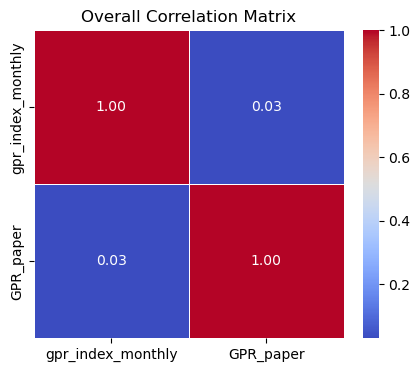

C:\Users\em18921\AppData\Local\Temp\ipykernel_21524\2500216986.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Correlation', data=yearly_corr, palette='coolwarm')


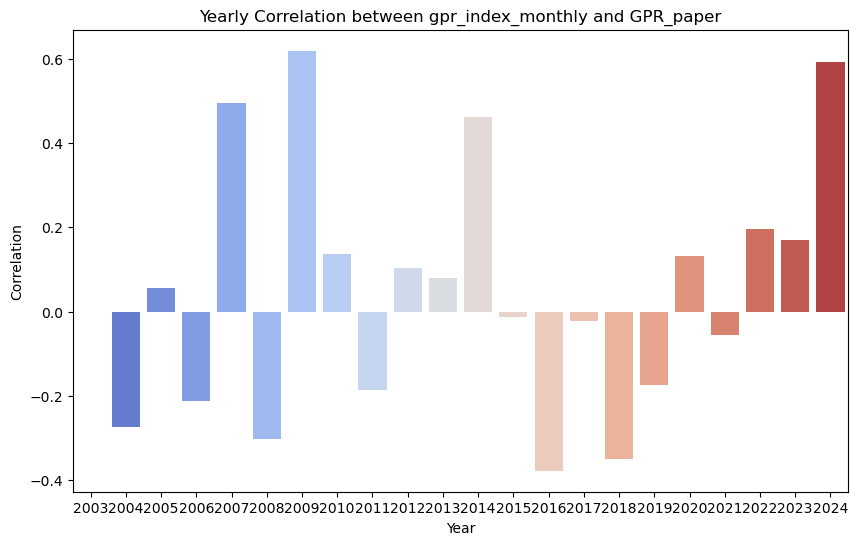

In [12]:
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_output_folder_16Dec\gpr_index_zhi_da_monthly.csv'
df = pd.read_csv(input_file_path)

# Group by Year and calculate correlation
yearly_corr = df.groupby('Year').apply(lambda group: group[['gpr_index_monthly', 'GPR_paper']].corr().iloc[0, 1])

overall_corr = df[['gpr_index_monthly', 'GPR_paper']] .corr()

# Reset index for better readability (optional)
yearly_corr = yearly_corr.reset_index(name='Correlation')

print(yearly_corr)
print(overall_corr)

import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for overall correlation
plt.figure(figsize=(5, 4))
sns.heatmap(overall_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Overall Correlation Matrix')
plt.show()

# Bar plot for yearly correlation
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Correlation', data=yearly_corr, palette='coolwarm')
plt.title('Yearly Correlation between gpr_index_monthly and GPR_paper')
plt.show()

## Code to get top 30 keywords for each year and month combination

In [96]:
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\cal_8_zhi_da.csv'
df = pd.read_csv(input_file_path)

def is_last_week(row):
    # Get last day of the month
    if row['date_calculated'].month == 12:
        next_month = row['date_calculated'].replace(year=row['date_calculated'].year + 1, month=1, day=1)
    else:
        next_month = row['date_calculated'].replace(month=row['date_calculated'].month +1, day=1)

    # last day of the current month
    last_day = next_month - pd.Timedelta(days=1)

    # Check if date is within last 7 days of the month
    return (last_day - row['date_calculated']).days < 7

# Filter dataframe for month 6 and 12 
df_filtered = df[df['Month'].isin([6, 12])]
#df_filtered['date_calculated'] = pd.to_datetime(df['date_calculated'])
#df_filtered = df_filtered[df_filtered.apply(is_last_week, axis=1)]

# create a function to get top 30 keywords
#def get_top_keywords(group):
 #   return group.nlargest(30, 'rank')

# group by year and month and apply function to dataset
#top_keywords = df_filtered.groupby(['Year', 'Month', 'Day'], group_keys=False).apply(get_top_keywords)

# reset index for better readability
#top_keywords.reset_index(drop=True, inplace=True)

# Output dataset to output folder
output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\top_30_keywords.csv'
df_filtered.to_csv(output_file_path, index=False)

df_filtered

,date,Year,Month,Day,batch_number,keyword_name,SVI,time_series_period_week,month_number,delta_SVI,...,winsorize_delta_residual,mean_residual,std_residual,normalize_residual,Adj Close,snp_monthly_returns,snp_Volatility,t_stat,date_calculated,rank
3,1/06/2004,2004,6,1,apidata_40,act of terrorism,11,6,6,-7,...,-2.727697,0.051947,2.417955,-1.149585,1140.839966,0.017989,0.004176,-0.348871,1/06/2004,155.0
9,1/12/2004,2004,12,1,apidata_40,act of terrorism,16,12,12,-1,...,-0.151555,0.051947,2.417955,-0.084163,1211.920044,0.032458,0.004339,-0.362469,1/12/2004,37.0
15,1/06/2005,2005,6,1,apidata_40,act of terrorism,8,18,6,-3,...,1.022303,0.051947,2.417955,0.401313,1191.329956,-0.000143,0.021280,-1.436746,1/06/2005,7.0
21,1/12/2005,2005,12,1,apidata_40,act of terrorism,10,24,12,-1,...,-0.151555,0.051947,2.417955,-0.084163,1248.290039,-0.000952,0.025554,-1.610193,1/12/2005,3.0
27,1/06/2006,2006,6,1,apidata_40,act of terrorism,5,30,6,-3,...,1.022303,0.051947,2.417955,0.401313,1270.199951,0.000087,0.021923,-1.803934,1/06/2006,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61225,1/12/2022,2022,12,1,apidata_17,world war,21,228,12,-3,...,-2.151555,-0.004826,5.911962,-0.363116,3839.500000,-0.058971,0.079708,-0.963405,1/12/2022,25.0
61231,1/06/2023,2023,6,1,apidata_17,world war,15,234,6,-11,...,-6.977697,-0.004826,5.911962,-1.179451,4450.379883,0.064727,0.044014,-0.835911,1/06/2023,37.0
61237,1/12/2023,2023,12,1,apidata_17,world war,22,240,12,-1,...,-0.151555,-0.004826,5.911962,-0.024819,4769.830078,0.044229,0.031784,-0.928147,1/12/2023,34.0
61243,1/06/2024,2024,6,1,apidata_17,world war,17,246,6,-8,...,-3.977697,-0.004826,5.911962,-0.672006,5460.479980,0.034670,0.009441,-0.968121,1/06/2024,34.0


## Code to download SnP 500 monthly data

## Performing operations in yahoo snp500_data 

## Get min, median and max values of SVI

In [106]:
input_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\geopoltiks_mon_final_dataset_2.csv'
df = pd.read_csv(input_file_path)
# Replace '<1' value to 0
df['SVI'] = df['SVI'].replace('<1', 0)

# Step 3: Convert SVI column to numeric
df['SVI'] = pd.to_numeric(df['SVI'], errors='coerce')

result_data = df.groupby('keyword_name')['SVI'].agg(['min', 'median', 'max']).reset_index()

output_file_path = r'C:\Users\em18921\Documents\Sentinels_indicator\Geopolitiks_monthly\geopolitiks monthly output files\monthly_SVI_metadata.csv'
result_data.to_csv(output_file_path, index=False)
result_data

,keyword_name,min,median,max
0,act of terrorism,0,5.0,18
1,act of war,6,29.0,100
2,aerial support,0,0.0,0
3,air battles,0,1.0,4
4,air force,43,60.0,100
...,...,...,...,...
240,weapons of mass destruction,0,0.0,100
241,what are sanctions in war,0,0.0,25
242,world order,26,46.0,100
243,world peace,1,2.0,32
